In [1]:
import sklearn
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import scipy as scp
from scipy import sparse
from mvlearn.cluster.mv_spherical_kmeans import MultiviewSphericalKMeans
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

np.random.seed(5)
NUM_SAMPLES = 200

In [2]:
#Load in the vectorized news group data from scikit-learn package
news = fetch_20newsgroups(subset='all')
all_data = np.array(news.data)
all_targets = np.array(news.target)
class_names = news.target_names

#A function to get the 20 newsgroup data
def get_data():    
    
    #Set class pairings as described in the multiview clustering paper
    view1_classes = ['comp.graphics','rec.motorcycles', 'sci.space', 'rec.sport.hockey', 'comp.sys.ibm.pc.hardware']
    view2_classes = ['rec.autos', 'sci.med','misc.forsale', 'soc.religion.christian','comp.os.ms-windows.misc']
    
    #Create lists to hold data and labels for each of the 5 classes across 2 different views
    labels =  [num for num in range(len(view1_classes)) for _ in range(NUM_SAMPLES)]
    labels = np.array(labels)
    view1_data = list()
    view2_data = list()
    
    #Randomly sample 200 items from each of the selected classes in view1
    for ind in range(len(view1_classes)):
        class_num = class_names.index(view1_classes[ind])
        class_data = all_data[(all_targets == class_num)]
        indices = np.random.choice(class_data.shape[0], NUM_SAMPLES)
        view1_data.append(class_data[indices])
    view1_data = np.concatenate(view1_data)
    
    #Randomly sample 200 items from each of the selected classes in view2
    for ind in range(len(view2_classes)):
        class_num = class_names.index(view2_classes[ind])
        class_data = all_data[(all_targets == class_num)]
        indices = np.random.choice(class_data.shape[0], NUM_SAMPLES)
        view2_data.append(class_data[indices])  
    view2_data = np.concatenate(view2_data)
    
    #Vectorize the data
    vectorizer = TfidfVectorizer()
    view1_data = vectorizer.fit_transform(view1_data)
    view2_data = vectorizer.fit_transform(view2_data)

    #Shuffle and normalize vectors
    shuffled_inds = np.random.permutation(NUM_SAMPLES * len(view1_classes))
    view1_data = sparse.vstack(view1_data)
    view2_data = sparse.vstack(view2_data)
    view1_data = np.array(view1_data[shuffled_inds].todense())
    view2_data = np.array(view2_data[shuffled_inds].todense())
    magnitudes1 = np.linalg.norm(view1_data, axis=1)
    magnitudes2 = np.linalg.norm(view2_data, axis=1)
    magnitudes1[magnitudes1 == 0] = 1
    magnitudes2[magnitudes2 == 0] = 1
    magnitudes1 = magnitudes1.reshape((-1,1))
    magnitudes2 = magnitudes2.reshape((-1,1))
    view1_data /= magnitudes1
    view2_data /= magnitudes2
    labels = labels[shuffled_inds]

    return view1_data, view2_data, labels

In [3]:
def compute_entropy(partitions, labels, k, num_classes):
    
    total_entropy = 0
    num_examples = partitions.shape[0]
    for part in range(k):
        labs = labels[partitions == part]
        part_size = labs.shape[0]
        part_entropy = 0
        for cl in range(num_classes):
            prop = np.sum(labs == cl) * 1.0 / part_size
            ent = 0
            if(prop != 0):
                ent = - prop * np.log2(prop)
            part_entropy += ent
        part_entropy = part_entropy * part_size / num_examples
        total_entropy += part_entropy
    return total_entropy

In [4]:
def randSpherical(n_clusters, n_feat1, n_feat2):
    c_centers1 = np.random.normal(0, 1, (n_clusters, n_feat1))
    c_centers1 /= np.linalg.norm(c_centers1, axis=1).reshape((-1, 1))
    c_centers2 = np.random.normal(0, 1, (n_clusters, n_feat2))
    c_centers2 /= np.linalg.norm(c_centers2, axis=1).reshape((-1, 1))
    return [c_centers1, c_centers2]

In [7]:
def getEntropies():
    
    v1_data, v2_data, labels = get_data()
    
    entropies = list()
    for num in range(1,11):
        
        centers = randSpherical(num, v1_data.shape[1], v2_data.shape[1])
        kmeans = MultiviewSphericalKMeans(n_clusters=num, init=centers, 
                                          n_init=1)
        pred = kmeans.fit_predict([v1_data, v2_data])
        ent = compute_entropy(pred, labels, num, 5)
        entropies.append(ent)
    print('done')
    return entropies

In [8]:
#Do spherical kmeans and get entropy values for each k for multiple trials
n_workers = 10
n_trials = 80
# seeds = np.random.randint(2**32 - 1, size = n_trials)
mult_entropies1 = Parallel(n_jobs=n_workers)(
    delayed(getEntropies)() for i in range(n_trials))  

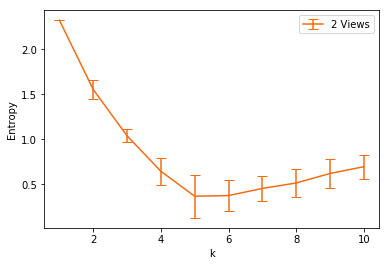

In [9]:
mult_entropies1 = np.array(mult_entropies1)
ave_m_entropies = np.mean(mult_entropies1, axis=0)
std_m_entropies = np.std(mult_entropies1, axis=0)
x_values = list(range(1, 11))
plt.errorbar(x_values, ave_m_entropies, std_m_entropies, capsize=5, color = '#F46C12')
plt.xlabel('k')
plt.ylabel('Entropy')
plt.legend(['2 Views'])
plt.rc('axes', labelsize=12)
plt.show()

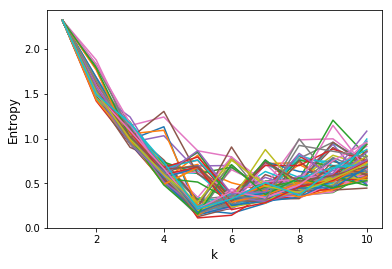

In [10]:
mult_entropies1 = np.array(mult_entropies1)
x_values = list(range(1, 11))
plt.plot(x_values, mult_entropies1.transpose())
plt.xlabel('k')
plt.ylabel('Entropy')
plt.rc('axes', labelsize=12)
plt.show()